<h1>Cat vs. Dog Image Classification</h1>
<h3><b>Focus:</b> Reducing Overfitting</h3>
<p>In this notebook we will build on the model we created in Notebook 1 to classify cats vs. dogs, and improve accuracy by employing a couple strategies to reduce overfitting: data augmentation and dropout.</p>

We will follow these steps:

 

1.   Explore how data augmentation works by making random transformations to training images.
2.  Add data augmentation to our data preprocessing.
3.   Add dropout to the convnet.
4.   Retrain the model and evaluate loss and accuracy.







<h1>Data Augmentation</h1>
Let's get familiar with the concept of data augmentation, an essential way to fight overfitting for computer vision models.

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, our model will never see the exact same picture twice. This helps prevent overfitting and helps the model generalize better.

This can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance. Let's get started with an example:

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range =0.2,
    shear_range = 0.2,
    zoom_range = 0.2 ,
    horizontal_flip =True,
    fill_mode = 'nearest'
)

<h2><b>Understanding Command</b></h2>


*   rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
*   width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.

*   shear_range is for randomly applying shearing transformations.
*   zoom_range is for randomly zooming inside pictures.
*   horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
*   fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.







In [2]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2020-04-02 11:44:36--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  58.5MB/s    in 1.1s    

2020-04-02 11:44:38 (58.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

Next, let's apply the datagen transformations to a cat image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants.

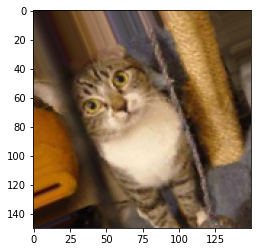

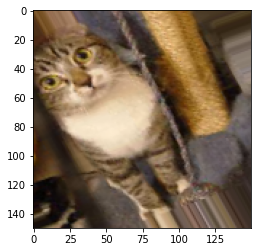

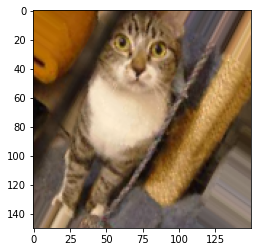

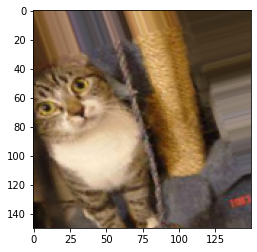

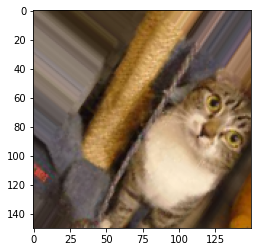

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

<h1>Add Data Augmentation to the Preprocessing Step</h1>

In [5]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


If we train a new network using this data augmentation configuration, our network will never see the same input twice. However the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to completely get rid of overfitting.

<h1>Adding Dropout</h1>

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

<h2>Retrain the Model</h2>

In [8]:
#Training
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
100/100 - 65s - loss: 0.7434 - acc: 0.5160 - val_loss: 0.6727 - val_acc: 0.5170
Epoch 2/15
100/100 - 65s - loss: 0.6754 - acc: 0.6125 - val_loss: 0.6212 - val_acc: 0.6580
Epoch 3/15
100/100 - 65s - loss: 0.6540 - acc: 0.6200 - val_loss: 0.5782 - val_acc: 0.6940
Epoch 4/15
100/100 - 65s - loss: 0.6395 - acc: 0.6430 - val_loss: 0.6775 - val_acc: 0.6270
Epoch 5/15
100/100 - 65s - loss: 0.6308 - acc: 0.6560 - val_loss: 0.5859 - val_acc: 0.6900
Epoch 6/15
100/100 - 65s - loss: 0.6130 - acc: 0.6715 - val_loss: 0.5486 - val_acc: 0.7150
Epoch 7/15
100/100 - 64s - loss: 0.6034 - acc: 0.6795 - val_loss: 0.5746 - val_acc: 0.6970
Epoch 8/15
100/100 - 65s - loss: 0.5963 - acc: 0.6875 - val_loss: 0.5436 - val_acc: 0.7220
Epoch 9/15
100/100 - 64s - loss: 0.5931 - acc: 0.6870 - val_loss: 0.5918 - val_acc: 0.6840
Epoch 10/15
100/100 - 64s - loss: 0.5782 - acc: 0.7010 - val_loss: 0.7337 - val_acc: 0.6430
Epoch 11/15
1

<h1>Evaluate the Results</h1>

Text(0.5, 1.0, 'Training and validation loss')

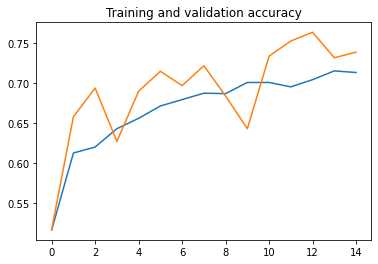

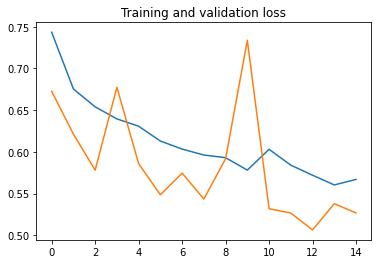

In [9]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

<h1>Clean Up</h1>

In [0]:
import signal
os.kill(os.getpid(), signal.SIGKILL)